## Using LDA to clean and cluster the complaint narratives
Instead of looking at per-product levels, we now use the entire dataset to group the issues together, and match that against the customer selected issues to see how that compares. We are trying the approach of [this paper](http://www.recoverydecisionscience.com/text-mining-reveals-hidden-trends-in-cfpb-complaint-narratives/) to see whether it can reproduce their results to create an useful prototype.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [210]:
import re
import numpy as np
import pandas as pd
import datetime

In [113]:
import spacy
nlp = spacy.load("en_core_web_sm")
#!python -m spacy download en_core_web_sm

In [211]:
import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [212]:
from preprocess.clean_and_tokenize import clean_text, tokenize

We tried to group the products together but in the end we don't need it - since we are only dealing with the complaint issues themselves. 

In [70]:
file = '../data/with_narrative.csv'
df = pd.read_csv(file)
df.drop_duplicates(subset='Consumer complaint narrative', inplace=True)

/Users/sueliu/Mudano/customer-complaints/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Get up to 99% of the issues (removes 61 types)

#### Clean and tokenize, save to file

In [91]:
issues_df = pd.DataFrame(df.Issue.value_counts()).reset_index()
issues_df['ratio'] = issues_df['Issue']/len(df)
issues_df['cum_ratio'] = np.cumsum(issues_df['ratio'])

In [101]:
model_df = df[df.Issue.isin(issues_df[issues_df.cum_ratio < 0.99]['index'].values)]
model_df['date'] = pd.to_datetime(model_df['Date sent to company'], format='%m/%d/%Y')
model_df = model_df[['date', 'Product', 'Issue', 'Consumer complaint narrative', 'Company', 'Complaint ID']]

model_df['cleaned'] = model_df['Consumer complaint narrative'].apply(clean)
tokenized = []
for output in tokenize(model_df['cleaned']):
    tokenized.append(output)
model_df['tokenized'] = tokenized

model_df.to_csv('../data/for_issue_lda.csv', index=False)

### Latent Dirichlet Allocation

In [213]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))

In [214]:
X = vectorizer.fit_transform(model_df.tokenized)

In [215]:
from sklearn.decomposition import LatentDirichletAllocation

In [247]:
def run_lda_expt(X, n_topics):
    lda_model = LatentDirichletAllocation(n_components=n_topics, doc_topic_prior=0.1, 
                                          topic_word_prior=0.1, random_state=42, n_jobs=-1)
    lda_model.fit(X)
    # Perplexity
    print("Model perplexity: {}".format(lda_model.perplexity(X)))
    with open('../output/lda_issues_{}_topics.pickle'.format(n_topics), 'wb') as f:
        pickle.dump(lda_model, f, pickle.HIGHEST_PROTOCOL)

In [248]:
import time

In [ ]:
n_topics_arr = [40, 45, 55, 60, 65]
for nt in n_topics_arr:
    t0 = time.time()
    run_lda_expt(X, nt)
    print('Time taken: {}s'.format(time.time()-t0))

In [219]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ",".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [220]:
n_top_words=10

In [221]:
count_feature_names = vectorizer.get_feature_names()
print_top_words(lda_model, count_feature_names, n_top_words)

Topic #0: loan,student,student loan,payment,pay,repayment,plan,year,school,program
Topic #1: address,mail,email,receive,send,return,notice,order,provide,deliver
Topic #2: company,loan,tell,sign,contact,contract,credit,say,ask,call
Topic #3: letter,send,receive,state,receive letter,request,send letter,letter state,fax,mail
Topic #4: report,credit,information,credit report,experian,bureau,credit bureau,agency,inaccurate,information credit
Topic #5: bank,check,money,account,fund,deposit,day,branch,check account,cash
Topic #6: account,verify,proof,original,provide,contract,verification,credit,report,verify account
Topic #7: date,address,account,numb,open,account numb,balance,creditor,report,live
Topic #8: mortgage,home,loan,house,refinance,pay,sell,year,mortgage company,mortgage payment
Topic #9: credit,card,credit card,year,ago,old,year ago,apply,application,limitation
Topic #10: report,credit,credit report,remove,account,transunion,bureau,credit bureau,show,remove credit
Topic #11: card,

In [223]:
lda_topics = lda_model.transform(X)

In [228]:
%matplotlib inline
import matplotlib.pyplot as plt

Importance [33  3 18  2 36 29 28 38 35 14 39 27  4 48 26  6 30 16 34 19 49 23 45  7
 10 22 47  5 17 42 31 43 24 25 11 37 15 41 40 13  9 20 21  1 32 12  0  8
 44 46]
Narrative: I was marked as late on XXXX XXXX ( Auto ) account XXXX. I do not think I was late per the attached dispute letter sent. I am asking for this matter to be looked into again and more specifically how your company investigated this information with XXXX XXXX. SEE ATTACHED.
Customer labelled issue: Problem with a credit reporting company's investigation into an existing problem


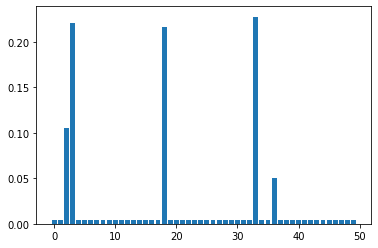

In [245]:
idx = 5
plt.bar(np.arange(50), lda_topics[idx,:])
print('Importance', np.argsort(lda_topics[idx, :])[::-1])
print('Narrative:', model_df['Consumer complaint narrative'][idx])
print('Customer labelled issue:', model_df['Issue'][idx])